In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import scipy
import importlib
import os, sys
import seaborn as sns
import tqdm
# from pandas_datareader import data
import networkx as nx
sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
sys.path.insert(0, 'C:/Users/ragna/Documents/Code/MMDGraph')

import graph_fun as gf
import importlib
# importlib.reload(sys.modules['graph_fun'])

#from rpy2.robjects.packages import importr
#import rpy2.robjects as ro
#import rpy2.robjects.numpy2ri
#from rpy2.robjects import pandas2ri
#rpy2.robjects.numpy2ri.activate()

from sklearn.covariance import graphical_lasso, GraphicalLasso, GraphicalLassoCV

Define function

# Read Data

<AxesSubplot:xlabel='date'>

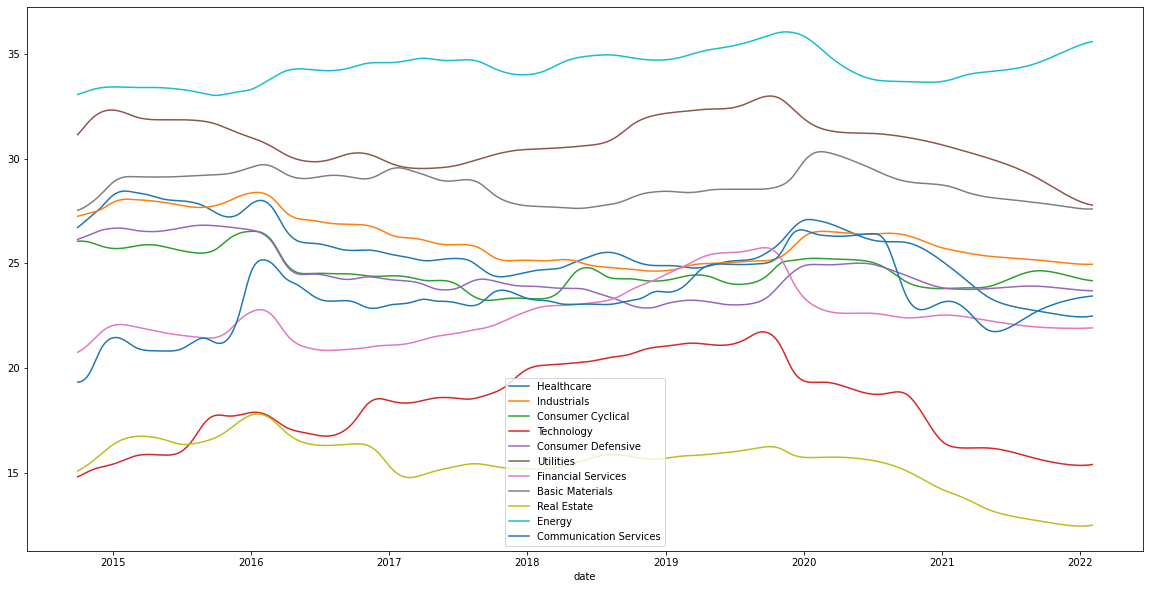

In [2]:
sector_gp = pd.read_pickle('../data/paper/sector_gp.pkl')
sector_gp.plot(figsize = (20,10))

# Sector ESG  lasso

Take ESG before and after intervention

In [3]:
after_shock = sector_gp.loc[sector_gp.index >= datetime.date(2020,1,1)]
before_shock = sector_gp.loc[sector_gp.index <= datetime.date(2019,10,1)]  # Not all scores change on same date, leave some margin
before_shock = before_shock.iloc[-after_shock.shape[0]:]
before_shock.shape == after_shock.shape

True

Define a grid search function for Friedman glasso algorithm

In [52]:
def glasso_grid_search(S, alphas, max_iter = 1000):

    costs = []
    for alpha in alphas:
        try:
            out = graphical_lasso(S, alpha = alpha, max_iter=max_iter, return_costs = True)
            if isinstance(out[2], list):
                costs.append(out[2][-1][0])
            else:
                costs.append(out[2][0])
        except FloatingPointError:
            costs.append(np.nan)
        except Warning:
            costs.append(np.nan)

    costs = np.array(costs)
    best_alpha_index = np.where(costs == np.nanmin(costs))

    out = graphical_lasso(S, alpha = alphas[best_alpha_index], max_iter=max_iter, return_costs = True)
    return out[1], costs

In [53]:
import warnings
warnings.filterwarnings("error")
alphas = np.linspace(0.02,1, 50)
prec, costs = glasso_grid_search(np.array(before_shock.iloc[0:(125+0)].corr()), alphas)


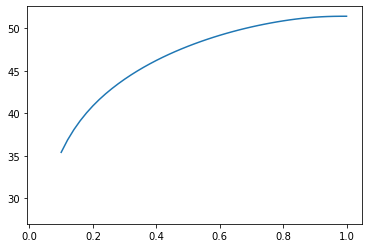

In [54]:
plt.plot(alphas, costs)

In [72]:
before_precs = []
after_precs = []
G_before = []
G_after = []
G_before_pos = []
G_after_pos = []
G_before_neg = []
G_after_neg = []
dates_before = []
dates_after = []
costs_after = []
costs_before = []

N = 125
alphas = np.linspace(0.04,0.5,10)
for i in tqdm.tqdm(range(0, after_shock.shape[0]-N,5)):

    dates_after.append(after_shock.index[i+N])
    dates_before.append(before_shock.index[i+N])

    # After shock
    names = {k:j for k, j in enumerate(after_shock.columns)}
    S = np.array(after_shock.iloc[i:(N+i)].corr())
    prec, costs = glasso_grid_search(np.array(after_shock.iloc[i:(N+i)].corr()), alphas, max_iter=100)
    costs_after.append(costs)
    after_precs.append(prec)
    np.fill_diagonal(prec,0)
    # All edges
    G = nx.from_numpy_array(prec)
    nx.set_node_attributes(G, names, "label")
    G_after.append(G)
    # positive edges
    prec_pos = prec.copy()
    prec_pos[prec_pos <0] = 0
    G = nx.from_numpy_array(prec_pos)
    nx.set_node_attributes(G, names, "label")
    G_after_pos.append(G)
    # negative edges
    prec_neg = prec.copy()
    prec_neg[prec_neg >0] = 0
    G = nx.from_numpy_array(prec_neg)
    nx.set_node_attributes(G, names, "label")
    G_after_neg.append(G)


    # Before shock
    names = {k:j for k, j in enumerate(before_shock.columns)}
    S = np.array(before_shock.iloc[i:(N+i)].corr())
    prec, costs = glasso_grid_search(np.array(before_shock.iloc[i:(N+i)].corr()), alphas, max_iter=100)
    costs_before.append(costs)
    before_precs.append(prec)
    np.fill_diagonal(prec,0)
    # All edges
    G = nx.from_numpy_array(prec)
    nx.set_node_attributes(G, names, "label")
    G_before.append(G)
        # positive edges
    prec_pos = prec.copy()
    prec_pos[prec_pos <0] = 0
    G = nx.from_numpy_array(prec_pos)
    nx.set_node_attributes(G, names, "label")
    G_before_pos.append(G)
    # negative edges
    prec_neg = prec.copy()
    prec_neg[prec_neg >0] = 0
    G = nx.from_numpy_array(prec_neg)
    nx.set_node_attributes(G, names, "label")
    G_before_neg.append(G)

100%|██████████| 128/128 [02:41<00:00,  1.26s/it]


<AxesSubplot:>

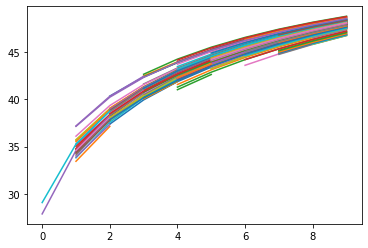

In [66]:
pd.DataFrame(np.array(costs_before).T).plot(legend = None)

In [57]:
# out = {'before_precs':before_precs, 'costs_before':costs_before, 'G_before':G_before,
#         'after_precs':after_precs, 'costs_after':costs_after, 'G_after':G_after}

# import pickle
# with open('../data/paper/esg_lasso.pkl', 'wb') as handle:
#     pickle.dump(out, handle)

Plot average degree of for the binary graphs. If weight then we have both positive and negative correlation.

6.5099431818181825
7.301136363636363
6.363636363636363
7.090909090909091


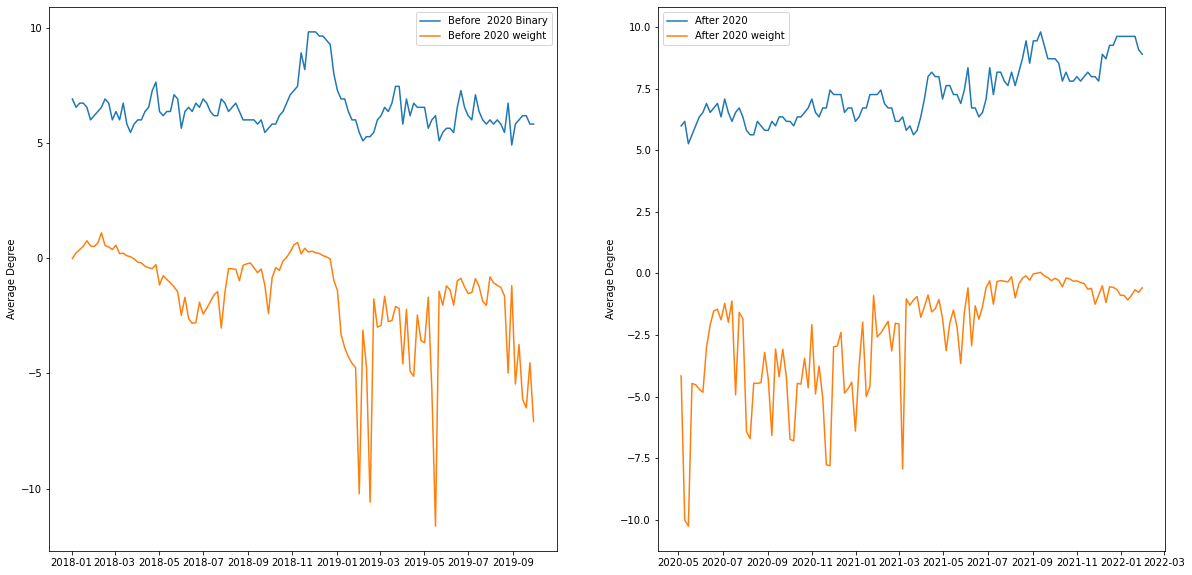

In [75]:
fig ,ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(dates_before, gf.avg_degree_list(G_before), label = 'Before  2020 Binary')
ax[0].plot(dates_before, gf.avg_degree_list(G_before,  weight = 'weight'), label = 'Before 2020 weight')
ax[0].set_ylabel('Average Degree')
ax[0].legend()
ax[1].plot(dates_after,gf.avg_degree_list(G_after), label = 'After 2020')
ax[1].plot(dates_after, gf.avg_degree_list(G_after,  weight = 'weight'), label = 'After 2020 weight')
ax[1].set_ylabel('Average Degree')
ax[1].legend()

print(np.mean(gf.avg_degree_list(G_before)))
print(np.mean(gf.avg_degree_list(G_after)))

print(np.median(gf.avg_degree_list(G_before)))
print(np.median(gf.avg_degree_list(G_after)))


Plot average degree of graphs defined by only positive correlation

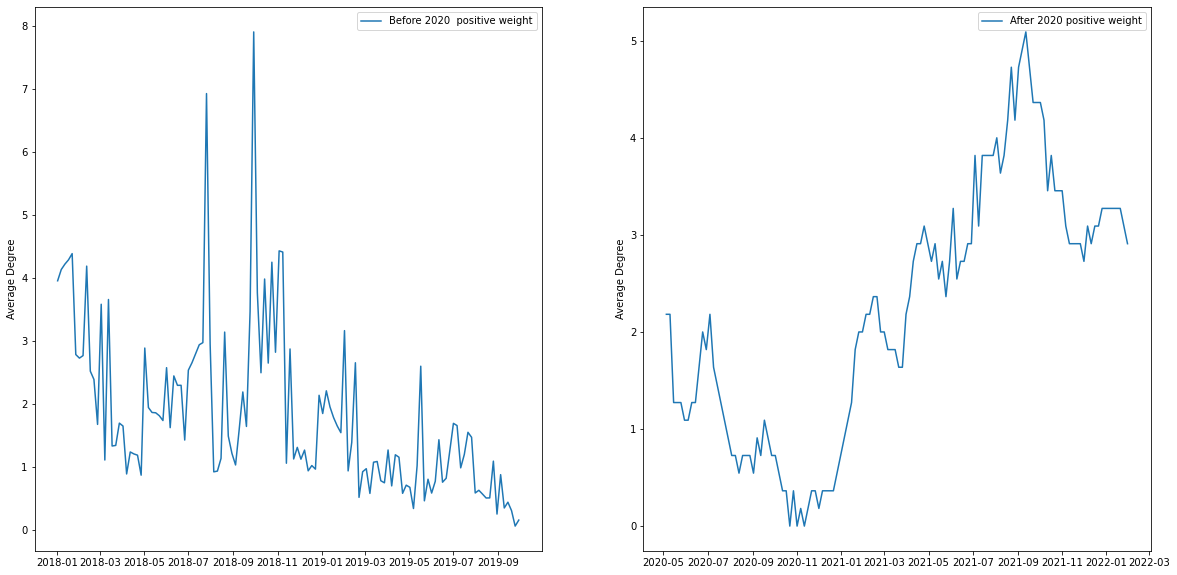

In [79]:
fig ,ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(dates_before, gf.avg_degree_list(G_before_pos,  weight = 'weight'), label = 'Before 2020  positive weight')
ax[0].set_ylabel('Average Degree')
ax[0].legend()
ax[1].plot(dates_after,gf.avg_degree_list(G_after_pos), label = 'After 2020 positive weight')
ax[1].set_ylabel('Average Degree')
ax[1].legend()


Plot average degree of graphs defined by only negative correlation

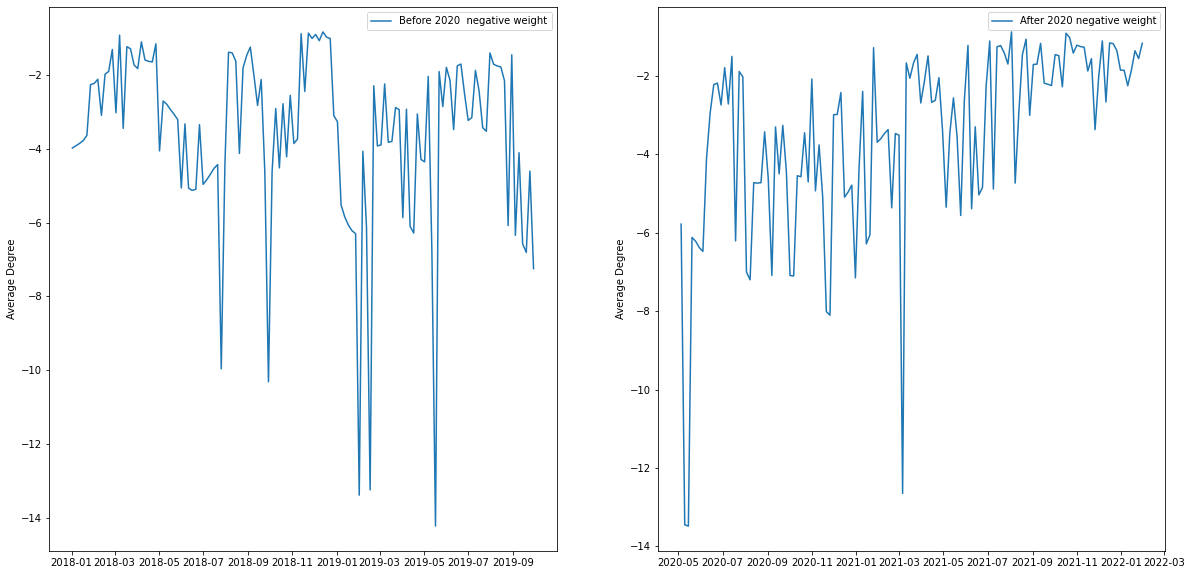

In [81]:
fig ,ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(dates_before, gf.avg_degree_list(G_before_neg,  weight = 'weight'), label = 'Before 2020  negative weight')
ax[0].set_ylabel('Average Degree')
ax[0].legend()
ax[1].plot(dates_after,gf.avg_degree_list(G_after_neg, weight = 'weight'), label = 'After 2020 negative weight')
ax[1].set_ylabel('Average Degree')
ax[1].legend()



In [ ]:
before_precs = []
after_precs = []
G_before = []
G_after = []
dates_before = []
dates_after = []

N = 125
alphas = np.linspace(0,1,100)
for i in tqdm.tqdm(range(0, after_shock.shape[0]-N,5)):

    dates_after.append(after_shock.index[i+N])
    dates_before.append(before_shock.index[i+N])



    S = after_shock.iloc[i:(N+i)]
    names = {i:j for i, j in enumerate(S.columns)}
    out = GraphicalLassoCV(max_iter = 1000).fit(S)
    prec = out.precision_
    after_precs.append(prec)
    np.fill_diagonal(prec,0)
    G = nx.from_numpy_array(prec)
    nx.set_node_attributes(G, names, "label")
    G_after.append(G)

    S = before_shock.iloc[i:(N+i)]
    names = {i:j for i, j in enumerate(S.columns)}
    out = GraphicalLassoCV(max_iter = 1000).fit(S)
    prec = out.precision_
    before_precs.append(prec)
    np.fill_diagonal(prec,0)
    G = nx.from_numpy_array(prec)
    nx.set_node_attributes(G, names, "label")
    G_before.append(G)



# Sector Return

To be done

# Correlation

In [3]:
corr, prec = gf.rolling_correlation(sector_gp, 125, 5, "kendall")
dates = sector_gp.index[125::5]
dates = dates[:len(corr)]

In [4]:
Gs_esg_full_raw = []

for i in range(len(corr)):
    A = corr[i].copy()
    np.fill_diagonal(A,0)

    Gs_esg_full_raw.append(nx.from_numpy_matrix(A))

for i in range(len(Gs_esg_full_raw)):
    edges = {(i[0], i[1]): np.sign(i[2]) for i in list(Gs_esg_full_raw[i].edges(data = 'weight'))}
    nx.set_edge_attributes(Gs_esg_full_raw[i], edges, "sign")

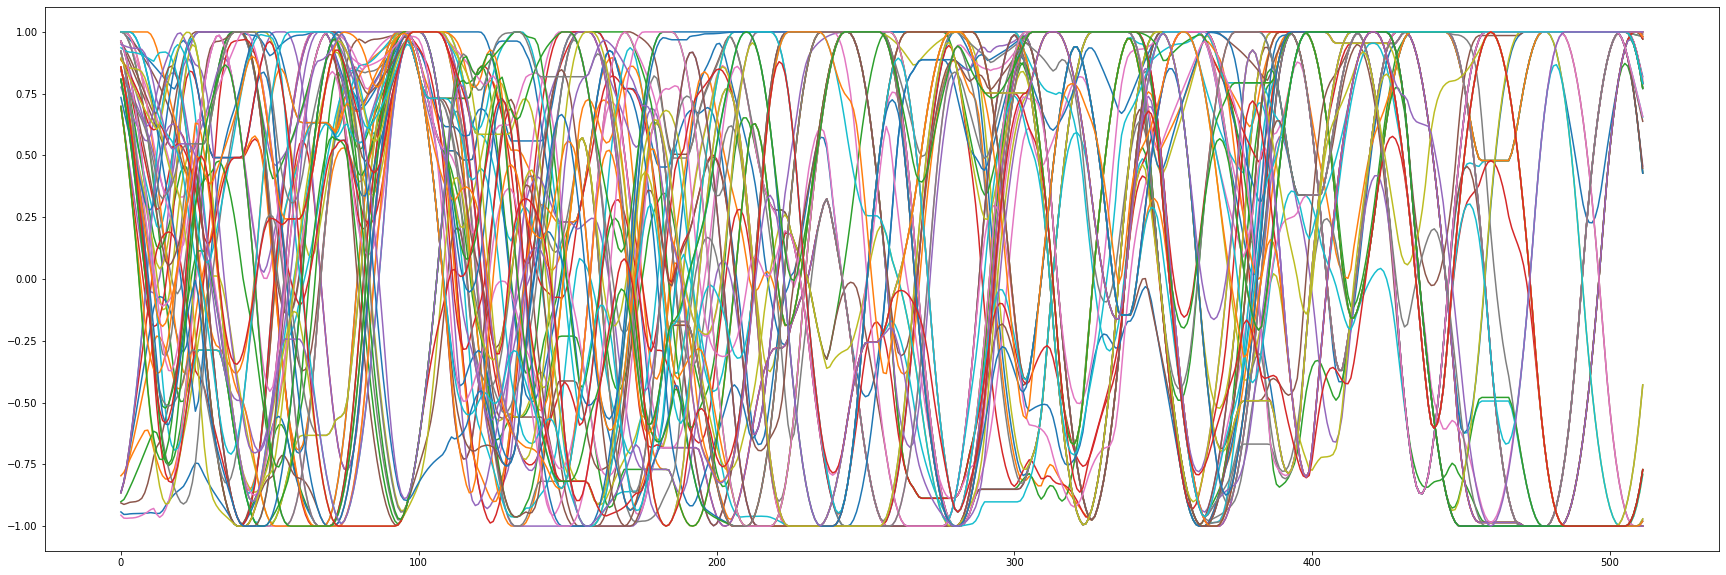

In [5]:
gf.plot_corr(corr)

In [6]:
importlib.reload(sys.modules['graph_fun'])
Gs_esg_full_w, Gs_esg_full, Gs_esg_full_signed = gf.gen_fullyconnected_threshold(corr, edge_type = None)
Gs_esg_full_w_pos, Gs_esg_full_pos, Gs_esg_full_signed_pos = gf.gen_fullyconnected_threshold(corr, edge_type = 'pos')
Gs_esg_full_w_neg, Gs_esg_full_neg, Gs_esg_full_signed_neg = gf.gen_fullyconnected_threshold(corr, edge_type = 'neg')

100%|██████████| 512/512 [00:07<00:00, 64.46it/s] 


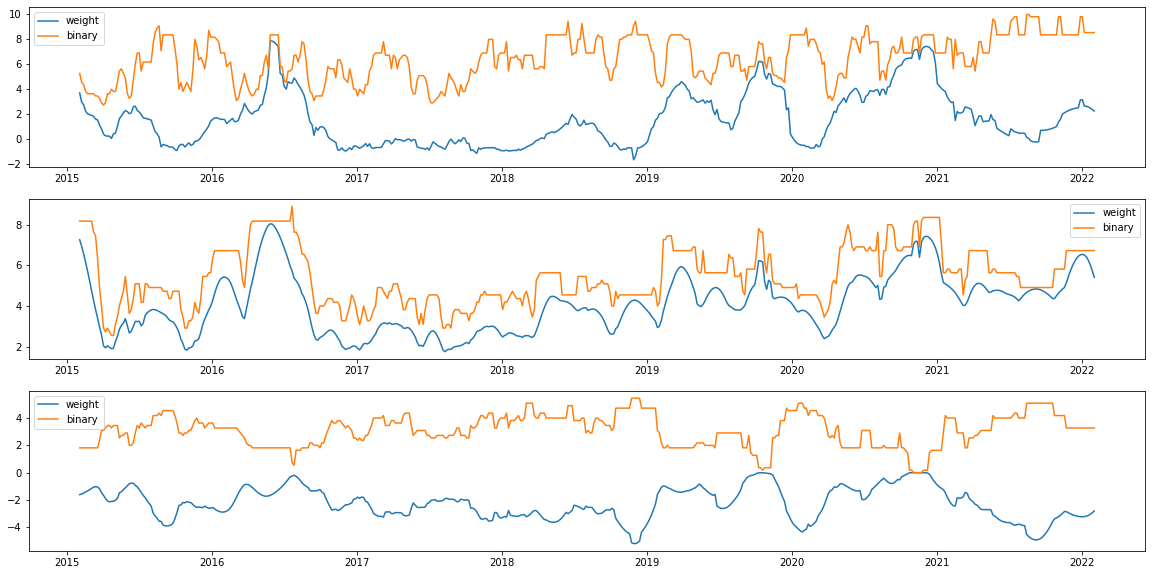

In [14]:
fig ,ax = plt.subplots(3,1, figsize = (20,10))

ax[0].plot(dates, gf.avg_degree_list(Gs_esg_full_w,  weight = 'weight'), label = 'weight')
ax[0].plot(dates,gf.avg_degree_list(Gs_esg_full), label = 'binary')
ax[0].legend()

ax[1].plot(dates,gf.avg_degree_list(Gs_esg_full_w_pos,  weight = 'weight'), label = 'weight')
ax[1].plot(dates,gf.avg_degree_list(Gs_esg_full_pos), label = 'binary')
ax[1].legend()

ax[2].plot(dates,gf.avg_degree_list(Gs_esg_full_w_neg,  weight = 'weight'), label = 'weight')
ax[2].plot(dates,gf.avg_degree_list(Gs_esg_full_neg), label = 'binary')
ax[2].legend()

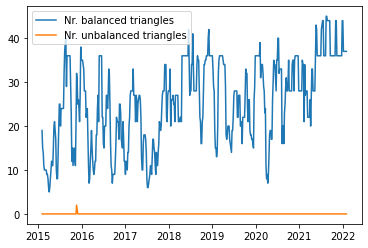

In [15]:
importlib.reload(sys.modules['graph_fun'])
balanced = [gf.cnt_balance(Gs_esg_full_signed[i])[0] for i in range(len(Gs_esg_full_signed))]
unbalanced = [gf.cnt_balance(Gs_esg_full_signed[i])[1] for i in range(len(Gs_esg_full_signed))]
plt.plot(dates, balanced, label = 'Nr. balanced triangles')
plt.plot(dates, unbalanced, label = 'Nr. unbalanced triangles')
plt.legend()

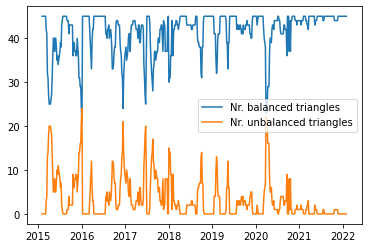

In [16]:
balanced = [gf.cnt_balance(Gs_esg_full_raw[i])[0] for i in range(len(Gs_esg_full_raw))]
unbalanced = [gf.cnt_balance(Gs_esg_full_raw[i])[1] for i in range(len(Gs_esg_full_raw))]
plt.plot(dates, balanced, label = 'Nr. balanced triangles')
plt.plot(dates, unbalanced, label = 'Nr. unbalanced triangles')
plt.legend()

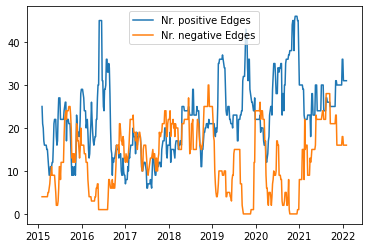

In [17]:
nr_pos = [gf.cnt_pos_neg(G, pos = 1) for G in Gs_esg_full_signed]
nr_neg = [gf.cnt_pos_neg(G, pos = -1) for G in Gs_esg_full_signed]
plt.plot(dates, nr_pos, label = 'Nr. positive Edges')
plt.plot(dates, nr_neg, label = 'Nr. negative Edges')
plt.legend()

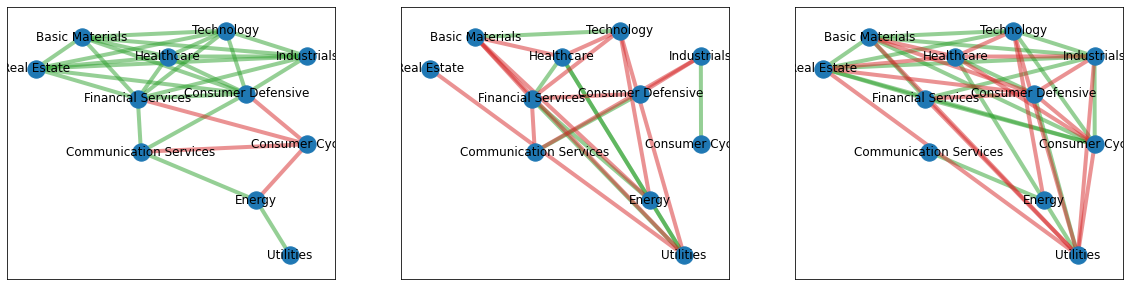

In [29]:
importlib.reload(sys.modules['graph_fun'])
pos = nx.kamada_kawai_layout(Gs_esg_full_signed[0], weight= None)
gf.plot_sign_network(Gs_esg_full_signed, [0, 50, 60], {i: sector for i, sector in enumerate(sector_gp.columns)}, (20,5), pos = pos)

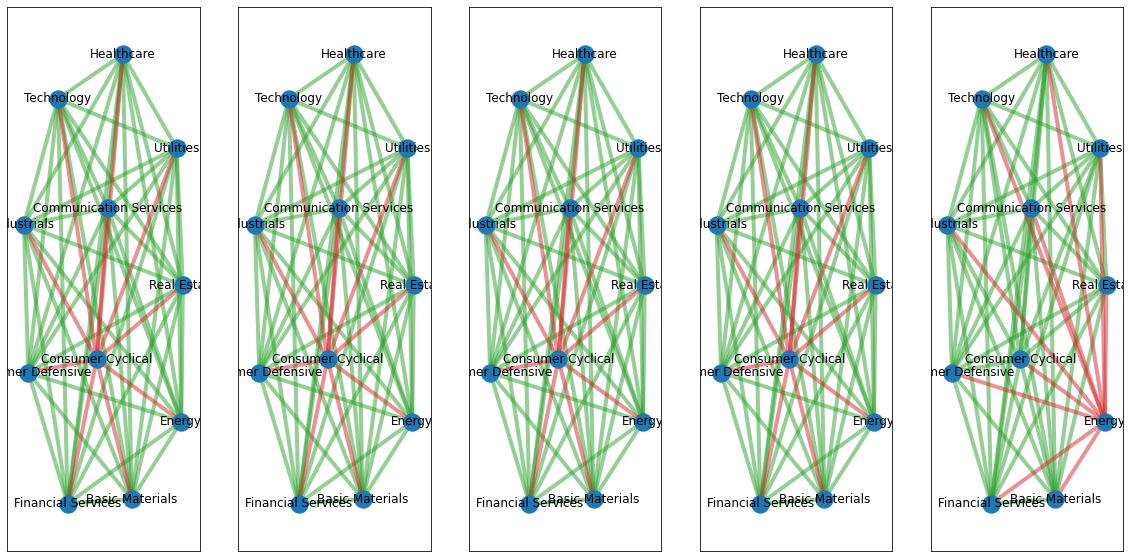

In [126]:
pos = nx.spring_layout(Gs_esg_full_raw[0],weight = None)
gf.plot_sign_network(Gs_esg_full_raw, [0, 1, 2, 3, 100], {i: sector for i, sector in enumerate(sector_gp.columns)}, (20,50), pos = pos)

In [ ]:

plt.plot(range(len(fully_connected_graphs)), ok)
import pickle
with open('../data/ESG_Graphs/Threshold/corr.pkl', 'wb') as handle:
    pickle.dump({'graphs':fully_connected_graphs, 'dates':dates}, handle)

with open('../data/ESG_Graphs/Threshold/sign.pkl', 'wb') as handle:
    pickle.dump({'graphs':fully_connected_graphs_signed, 'dates':dates}, handle)